<tr width="100%" style="border: none;">
 <td style="border: none;" width="120px">
    <img align="left" src="https://i.imgur.com/zC3NxsV.png" width="150px"/> 
  </td>
  <td style="border: none;" width="80%">
    <h1><a>Paralelismo em Julia: @threads e @spawn</a></h1>
    <td>
</tr>
<tr width="100%" style="border: none; text-align: left">
    <td colspan="2" style="border: none; text-align: left">
        <body> Leandro Bataglia, Pedro Machado, Gabriel Marinho, <br> Filipe Braida, Juliana Zamith, Leandro Alvim e Raul Ferreira </body>
    </td>
    </tr>

## Contexto 

Julia oferece diversas opções para o programador desenvolver paralelismo na linguagem. Essas funcionalidades estão em diversos estágios de desenvolvimento:
  - Multithreading
  - Pacote Distributed: https://docs.julialang.org/en/v1/manual/distributed-computing/
  - Wrappers para MPI: https://juliaparallel.github.io/MPI.jl/stable/
  - GPU em Julia: https://juliagpu.org/
  - Alguns pacotes utilizam threads para paralelizar operações quando disponível, como o BLAS
  
Nesta parte do minicurso serão abordadas as funcionalidades do uso de threads da linguagem Julia\*, implementável através das macros de paralelização. O multithreading em Julia tem poucos recursos, e em 2019 teve novas funcionalidades adicionadas à linguagem, em especial thread-safe, I/O, scheduling dinâmico e uma macro nova, `@spawn`. Para mais informações sobre as adições de 2019: https://julialang.org/blog/2019/07/multithreading/
   
\* No Julia, até o presente momento, não é possível alterar a quantidade de threads em tempo de execução. Caso queira conhecer como configurar a quantidade de threads em Julia, veja o notebook 5 deste minicurso sobre como configurar o ambiente para multithreading.

## @threads for loops

A macro `@threads` é usada comumente para paralelismo de dados.
Portanto, é normalmente associada a loops, e tem como funcionalidade dividir as iterações do loop entre as threads previamente definidas.
O modelo atual da macro @threads define como tarefa o conjunto de iterações atribuído à thread. Essas tarefas são enviadas para um scheduler, para execução. No caso do `@threads` o scheduling é estático, e a quantidade de iterações em cada thread é igual, independente da carga de trabalho associada a cada iteração.

In [ ]:
using Pkg
Pkg.add("BenchmarkTools")
Pkg.add("Plots")

In [2]:
using BenchmarkTools
using Base.Threads
using Plots
import Base.Threads.@spawn
import Base.Threads.@threads

In [3]:
@which @threads
# para mais informações sobre a macro

@threads(__source__::LineNumberNode, __module__::Module, args...) in Base.Threads at threadingconstructs.jl:118

In [4]:
#Exemplo de divisão de iterações de uma matrix 10x10 entre 4 threads
matrix = zeros(Int64, 10, 10)
@threads for i in 1:length(matrix)
    matrix[i] = threadid()
end
matrix

10×10 Array{Int64,2}:
 1  1  1  2  2  3  3  3  4  4
 1  1  1  2  2  3  3  3  4  4
 1  1  1  2  2  3  3  3  4  4
 1  1  1  2  2  3  3  3  4  4
 1  1  1  2  2  3  3  3  4  4
 1  1  2  2  2  3  3  4  4  4
 1  1  2  2  2  3  3  4  4  4
 1  1  2  2  2  3  3  4  4  4
 1  1  2  2  2  3  3  4  4  4
 1  1  2  2  2  3  3  4  4  4

In [ ]:
#Exemplo
@threads for i in 1:nthreads()
    sleep(threadid())
    println("thread ",threadid()," done sleeping")
end

#### Exemplo de redução: soma dos valores de um Array

In [6]:
a = rand(10_000_000);

In [7]:
# versão sequencial
function baseline_sum(arr)
    result::eltype(arr) = zero(eltype(arr))
    for i in arr
        result += i
    end
    return result
end
baseline_sum(a)

4.999753982500469e6

#### Avaliação da implementação

Para avaliação de desempenho, será usado o pacote BenchmarkTools. Os resultados apresentados são referentes à mediana do tempo de execução do benchmark.

In [8]:
metric = median(@benchmark baseline_sum(a))

BenchmarkTools.TrialEstimate: 
  time:             15.787 ms
  gctime:           0.000 ns (0.00%)
  memory:           16 bytes
  allocs:           1

Vamos colocar os valores de benchmarking da mediana em um dicionário para criar um gráfico ao final da experiência com as funções utilizadas.

In [9]:
dict = Dict{String, Float64}()
push!(dict, "seq"=> metric.time/10e5)

Dict{String,Float64} with 1 entry:
  "seq" => 15.7869

In [10]:
# Exemplo 1 - sem compartilhamento
function threaded_sum(arr)
    results = zeros(eltype(arr), nthreads())
    @threads for id in 1:nthreads()             #@threads gera um closure
        acc = zero(eltype(arr))                 #cada thread tem um acc localmente 
        len = div(length(arr), nthreads())      
        domain = ((id-1)*len+1):id*len          #cada thread trabalha 1/nthreads() do array
        for i in domain          
            acc += arr[i]
        end
        results[id] = acc                       #cada soma parcial é posta em uma variável no escopo acima
    end
    sum(results)                                #soma os resultados
end

threaded_sum (generic function with 1 method)

Como, neste exemplo específico estamos lidando com operações de ponto flutuante, a ordem das operações importa. Portanto, ao paralelizarmos o código, podemos ter resultados diferentes, o que não significa que o resultado esteja incorreto.

In [11]:
threaded_sum(a) ==  baseline_sum(a)

false

In [12]:

threaded_sum(a) ≈ baseline_sum(a)

true

In [13]:
metric_threaded_sum = median(@benchmark threaded_sum(a));
push!(dict, "ex_1"=> metric_threaded_sum.time/10e5)

Dict{String,Float64} with 2 entries:
  "seq"  => 15.7869
  "ex_1" => 5.5145

É claro que, quando lidamos com um acesso à memória compartilhada, é preciso com data race e false sharing. Nenhuma macro vai cuidar disso, é preciso construir os algoritmos para evitar que data races e false sharings aconteçam.

In [14]:
# versão paralela 2 - condição de corrida
function naive_sum(arr)
    total = zero(eltype(arr))
    @threads for i in arr
        total += i
    end
    return total
end

naive_sum (generic function with 1 method)

In [15]:
naive_sum(a)

1.2505808018954105e6

In [16]:
naive_sum(a) ≈ baseline_sum(a)

false

In [17]:
# Exemplo 3: false sharing
function false_sharing_sum(arr)
    partial = zeros(eltype(arr), nthreads())
    @threads for i in 1:length(arr)
        partial[threadid()] += arr[i]
    end
    sum(partial)
end

false_sharing_sum (generic function with 1 method)

In [18]:
false_sharing_sum(a) ≈ baseline_sum(a)

true

In [19]:
metric_fs_sum = median(@benchmark false_sharing_sum(a));
push!(dict, "ex_3"=> metric_fs_sum.time/10e5)

Dict{String,Float64} with 3 entries:
  "seq"  => 15.7869
  "ex_3" => 15.8121
  "ex_1" => 5.5145

## Atomics e Locks - consertar

Para evitar condição de corrida, Julia possui permite definir operações atômicas além de permitir o uso de Locks para definir uma região crítica. Contudo, vale lembrar que o uso de operações atômicas e Locks são extremamente caras, então é aconselhável usá-las o mínimo possível para não comprometer performance.

In [20]:
# Exemplo 4: Uso de variável atômica
function naive_atomic_sum(arr)
    total = Atomic{eltype(arr)}(0)
    acc = zero(eltype(arr))
    @threads for i in 1:length(arr)
        atomic_add!(total, arr[i])
    end
    return total[]
end

naive_atomic_sum (generic function with 1 method)

In [21]:
naive_atomic_sum(a) ≈ baseline_sum(a)

true

In [22]:
@btime naive_atomic_sum(a)

  276.780 ms (25 allocations: 3.06 KiB)


4.999753982500869e6

In [23]:
# Exemplo 5: melhorando o uso da operação atômica
function sum_thread_atomic(A)
   r = Atomic{eltype(A)}(zero(eltype(A)))
   len, rem = divrem(length(A), nthreads()) #calcula a divisão do array
   @threads for t in 1:nthreads()
      partial = zero(eltype(A))
      for i in (1:len) .+ (t-1)*len
         partial += A[i]
      end
      atomic_add!(r, partial)
    end
   result = r[]
   #processa os dados restantes
   for i in length(A)-rem+1:length(A)
      result += A[i]
   end
   return result
end

sum_thread_atomic (generic function with 1 method)

In [24]:
sum_thread_atomic(a) ≈ baseline_sum(a)

true

In [25]:
metric_atomic = median(@benchmark sum_thread_atomic(a));
push!(dict, "ex_5"=> metric_atomic.time/10e5)

Dict{String,Float64} with 4 entries:
  "seq"  => 15.7869
  "ex_3" => 15.8121
  "ex_5" => 5.53464
  "ex_1" => 5.5145

## Lock

In [26]:
# Exemplo #6: Utilização de Lock (definindo uma região crítica) 
function sum_thread_lock(A)
    result = zero(eltype(A))
    cond = ReentrantLock()
    len, rem = divrem(length(A), nthreads())
    @threads for t in 1:nthreads()
        partial = zero(eltype(A))
        for i in (1:len) .+ (t-1)*len
             partial += A[i]
        end
        lock(cond)
        result += partial
        unlock(cond)
    end
    for i in length(A)-rem+1:length(A)
        result += A[i]
    end
    return result
end

sum_thread_lock (generic function with 1 method)

In [27]:
sum_thread_lock(a) ≈ baseline_sum(a)

true

In [28]:
metric_lock = median(@benchmark sum_thread_lock(a));
push!(dict, "ex_6" => metric_lock.time/10e5)

Dict{String,Float64} with 5 entries:
  "seq"  => 15.7869
  "ex_6" => 5.56127
  "ex_3" => 15.8121
  "ex_5" => 5.53464
  "ex_1" => 5.5145

**Utilizando a macro inbounds**

In [29]:
# Exemplo 7: Utilização com inbounds
function inbounds_mt_sum(arr)
    results = zeros(eltype(arr), nthreads())    #cria um vetor de resultados
    @threads for id in 1:nthreads()             #@threads gera um closure
        acc = zero(eltype(arr))                 #cada thread tem um acc localmente 
        len = div(length(arr), nthreads())      
        domain = ((id-1)*len+1):id*len          #cada thread trabalha 1/nthreads() do array
        for i in domain          
            @inbounds acc += arr[i]             #omite a checagem de borda
        end
        results[id] = acc                       #cada soma parcial é posta em uma variável no escopo acima
    end
    sum(results)                                #soma os resultados
end

inbounds_mt_sum (generic function with 1 method)

In [30]:
metric_inbounds = median(@benchmark inbounds_mt_sum(a));
push!(dict, "ex_7"=> metric_inbounds.time/10e5)

Dict{String,Float64} with 6 entries:
  "seq"  => 15.7869
  "ex_6" => 5.56127
  "ex_3" => 15.8121
  "ex_5" => 5.53464
  "ex_7" => 5.53319
  "ex_1" => 5.5145

In [31]:
inbounds_mt_sum(a) ≈ baseline_sum(a)

true

#### Detalhe de implementação

O uso de @inbounds X desempenho!

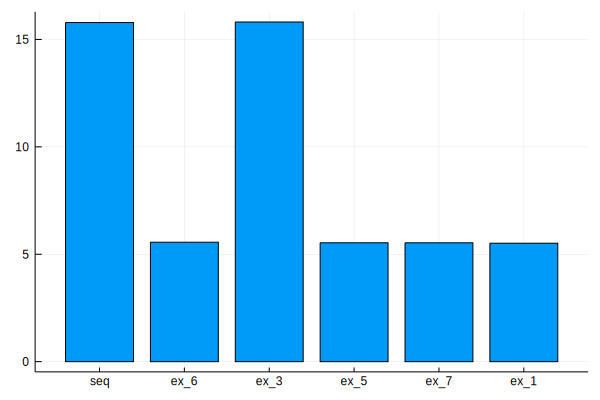

In [32]:
plt = bar!(dict, legend=false)

# @spawn

`@spawn` é a nova macro que foi adicionada em 2019 à linguagem, e se destina a paralelismo de tarefas. Ao contrário do `@threads`, que tem um conjunto de iterações associado a uma tarefa que ocorre em cada thread. `@spawn` realiza o scheduling dinâmico de tarefas.

Uma tarefa é uma corrotina, e quando a tarefa é criada, ela precisa ser enviada para o scheduler. Assim que a tarefa termina sua execução, é possível recuperar o resultado da computação com o `fetch()`.

In [ ]:
a1() = sum(i for i in 1:1000);
b = @task a1();
istaskstarted(b)

In [ ]:
schedule(b)

In [ ]:
istaskdone(b)

In [ ]:
fetch(b)

No `@spawn` a tarefa é associada pelo scheduler a uma thread disponível.

In [37]:
# Exemplo #1: Uso básico do @spawn
function task_spawn()
    for i = 1:10
        @spawn print(threadid(), " ")
    end
end

task_spawn (generic function with 1 method)

In [ ]:
task_spawn()

In [46]:
# Exemplo #2: Paralelização funcional - soma recursiva
b = rand(10_000)
function spawn_sum!(A::Vector{Float64}, lo, hi)
    if lo == hi
        return A[lo]
    end
    mid = (hi + lo + 1) >> 1
    left = @spawn spawn_sum!(A, lo, mid-1)
    rigth = @spawn spawn_sum!(A, mid, hi)
    return fetch(left) + fetch(rigth)
end

spawn_sum! (generic function with 1 method)

In [40]:
@btime spawn_sum!(b, 1, length(b))

  12.652 ms (140241 allocations: 14.96 MiB)


4974.132163331142

In [41]:
# Exemplo 3: paralelização funcional - Mergesort recursivo
function psort!(v, lo::Int=1, hi::Int=length(v))
    if lo >= hi                       # 1 or 0 elements; nothing to do
        return v
    end
    if hi - lo < 100_000               # below some cutoff, run in serial
        sort!(view(v, lo:hi), alg = MergeSort)
        return v
    end
    mid = (lo+hi)>>>1                 # find the midpoint
    half = @spawn psort!(v, lo, mid)  # task to sort the lower half; will run
    psort!(v, mid+1, hi)              # in parallel with the current call sorting the upper half                    
    wait(half)                        # wait for the lower half to finish
    temp = v[lo:mid]                  # workspace for merging
    i, k, j = 1, lo, mid+1            # merge the two sorted sub-arrays
    @inbounds while k < j <= hi
        if v[j] < temp[i]
            v[k] = v[j]
            j += 1
        else
            v[k] = temp[i]
            i += 1
        end
        k += 1
    end
    @inbounds while k < j
        v[k] = temp[i]
        k += 1
        i += 1
    end
    return v
end

psort! (generic function with 3 methods)

In [ ]:
a = rand(10_000_000)
psort!(a)

In [43]:
# Exemplo 3: paralelização funcional - vetor de primos
function prime_check(n::Int)
    for i = 2:n/2
        if n%i == 0
            return nothing
        end
    end
    return n
end
function primes_spawn(number::Int)
    vec = []
    cond = ReentrantLock()
    @sync for i = 2:number
        @spawn begin
            n = prime_check(i)
            if n != nothing
                lock(cond)
                push!(vec, n)
                unlock(cond)
            end
        end
    end
    return vec
end

primes_spawn (generic function with 1 method)

In [ ]:
primes_spawn(100)

Este minicurso abordou o paralelismo em memória compartilhada. Entretanto, Julia possui macros específicas para paralelização em memória distribuída. Segue o link para apresentações sobre esta temática:

- [Julia Distributed](https://docs.google.com/presentation/d/1YHGJ_WIikyFrxDLn_RTsC5GiMo2aR5-IybWkr_CIenM/edit?usp=sharing) 
- [DistributedArrays](https://docs.google.com/presentation/d/1Yc2sxBytRguS_ZteT5lOgyuAZC5hRscvamfEmVUV8G8/edit?usp=sharing)
- [MPI.jl](https://docs.google.com/presentation/d/1ehU5Fdb6FsPTlgPX0FpyjQkK46f8hQOOJtYoC_5YJkY/edit?usp=sharing)